In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, AveragePooling2D
from keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from keras.layers import Activation, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.utils import plot_model, to_categorical
from keras import backend as K
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Extract Needed Data

In [2]:
image_directory = 'data/UCMerced_Landuse/Images'
# category_names_all = os.listdir(image_directory)
# print('Total categories: {}'.format(len(category_names_all)))
# for category in category_names_all:
#     print('{}: {}'.format(category, len(os.listdir(image_directory+'/'+category))))

category_names = [
    'agricultural',
    'forest',
    'mobilehomepark',
    'overpass',
    'parkinglot',
    'river',
    'runway',
    'sparseresidential'
]
num_images = 100 # per category
nb_classes = len(category_names)
patch_size = 256
channels = 3

images_orig = []
labels_num = []
for i in range(nb_classes):
    for j in range(num_images):
        img_path = os.path.join(image_directory, category_names[i], category_names[i]+'{:02d}.tif'.format(j))

        # read and resize image
        img = Image.open(img_path)
        resized_img = img.resize((patch_size//4, patch_size//4), Image.LANCZOS)
        arr = np.asarray(resized_img)

        images_orig.append(arr)
        labels_num.append([i])

images_orig = np.array(images_orig)
images_orig = images_orig.astype('float32')
images_orig /= 255.0
labels_num = np.array(labels_num)
np.save('data/images_orig_multiclass.npy', images_orig)
np.save('data/labels_num_multiclass.npy', labels_num)

# Divide Dataset

In [3]:
num_images = 100 # per category
nb_classes = len(category_names)
patch_size = 256
channels = 3

images_orig = np.load('data/images_orig_multiclass.npy')
labels_num = np.load('data/labels_num_multiclass.npy')
labels = to_categorical(labels_num, nb_classes)

x_train, x_test, y_train, y_test = train_test_split(images_orig, labels, test_size=0.2,
                                                    stratify=labels, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25,
                                                    stratify=y_train, random_state=2023)

# Build the Model

In [4]:
input_shape = (64, 64, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
prob_drop = 0.5

def build_CNN_Base():
    model = Sequential()

    # convolutional 1
    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    # convolutional 2
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    # convolutional 3
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Flatten())

    # fully connected 1
    model.add(Dense(128, activation='relu'))

    # fully connected 2
    model.add(Dense(64, activation='relu'))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

def build_CNN_L2():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))

    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

def build_CNN_Dropout():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1,1), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

def build_CNN_BatchNormalization():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=(1,1), padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1,1), padding='same',))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1,1), padding='same',))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

def build_CNN_All():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=(1,1), padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1,1), padding='same',))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1,1), padding='same',))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(rate=prob_drop))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

model = build_CNN_All()

# Data Augmentation

Total Images:  9


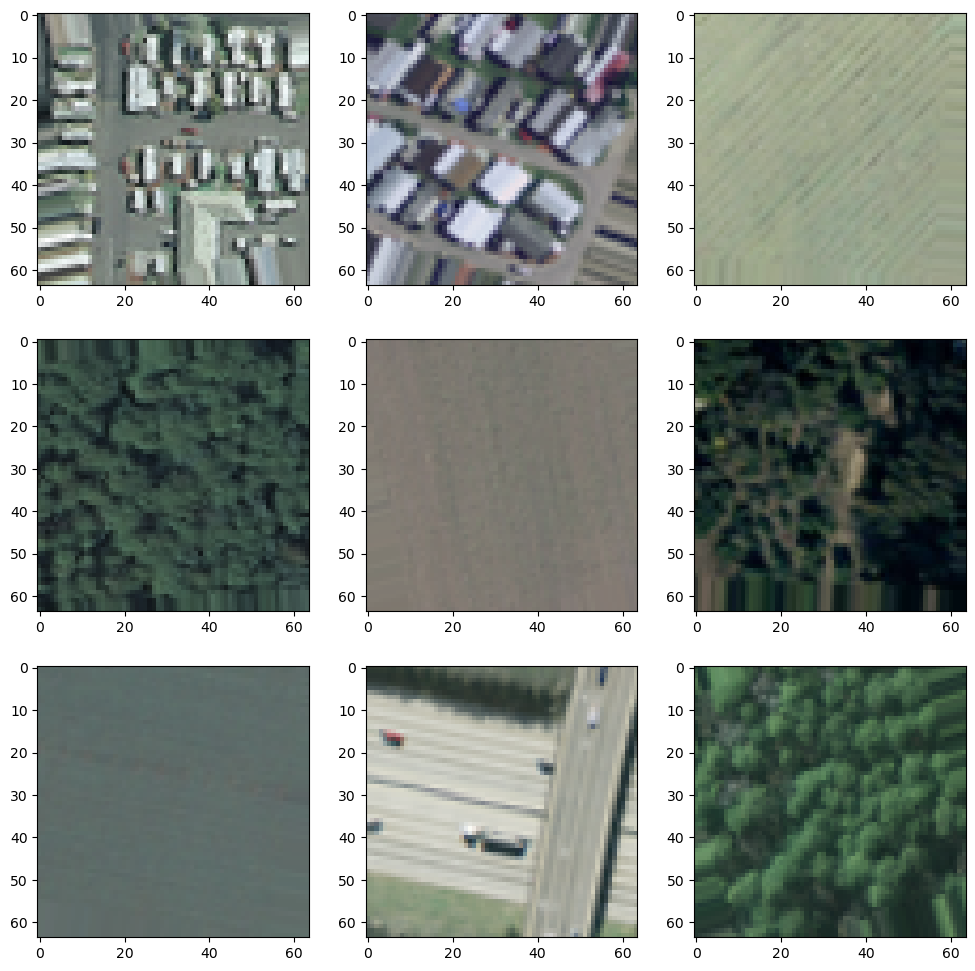

In [5]:
image_gen = ImageDataGenerator(
    zoom_range=0.1,
    width_shift_range=5,
    height_shift_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20
)

image_gen_test = ImageDataGenerator()

plt.figure(figsize=(12,12))
for x_batch, y_batch in image_gen.flow(x_train, y_train, batch_size=9):
    print('Total Images: ', len(x_batch))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(64,64,3))
    plt.show()
    break

In [6]:
train_gen = image_gen.flow(np.array(x_train), y_train, batch_size=32, shuffle=True)
val_gen = image_gen.flow(np.array(x_val), y_val, batch_size=32, shuffle=True)

# Train the Model

In [7]:
epochs = 500
base_learning_rate = 0.0001
batch_size = 32
batches_per_epoch = y_train.shape[0]//batch_size
validation_steps = y_val.shape[0]//batch_size

In [8]:
opt = Adam(learning_rate=base_learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
cp_best_model = 'model/multiclass_bm.hdf5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=60)
mc = ModelCheckpoint(cp_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [10]:
print('training ...')
history = model.fit(
    x=train_gen,
    steps_per_epoch=batches_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[es,mc])
print('done')

training ...
Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to model\multiclass_bm.hdf5
15/15 - 7s - loss: 6.2086 - accuracy: 0.1833 - val_loss: 5.4489 - val_accuracy: 0.1250 - 7s/epoch - 479ms/step
Epoch 2/500


F:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.12500
15/15 - 5s - loss: 5.3542 - accuracy: 0.2146 - val_loss: 5.4694 - val_accuracy: 0.1250 - 5s/epoch - 347ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.12500 to 0.18125, saving model to model\multiclass_bm.hdf5
15/15 - 5s - loss: 5.2004 - accuracy: 0.2875 - val_loss: 5.2485 - val_accuracy: 0.1813 - 5s/epoch - 359ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.18125 to 0.25625, saving model to model\multiclass_bm.hdf5
15/15 - 5s - loss: 5.1758 - accuracy: 0.2333 - val_loss: 5.0669 - val_accuracy: 0.2562 - 5s/epoch - 350ms/step
Epoch 5/500

Epoch 5: val_accuracy improved from 0.25625 to 0.38125, saving model to model\multiclass_bm.hdf5
15/15 - 5s - loss: 5.0895 - accuracy: 0.2500 - val_loss: 4.9746 - val_accuracy: 0.3812 - 5s/epoch - 352ms/step
Epoch 6/500

Epoch 6: val_accuracy did not improve from 0.38125
15/15 - 5s - loss: 5.0560 - accuracy: 0.2750 - val_loss: 4.9282 - val_accuracy: 0.3562 - 5s/epoch - 360ms/step


Epoch 45: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 3.1214 - accuracy: 0.4187 - val_loss: 2.9237 - val_accuracy: 0.5625 - 5s/epoch - 332ms/step
Epoch 46/500

Epoch 46: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 3.0871 - accuracy: 0.4271 - val_loss: 3.0366 - val_accuracy: 0.5625 - 5s/epoch - 351ms/step
Epoch 47/500

Epoch 47: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 3.0288 - accuracy: 0.4583 - val_loss: 2.9332 - val_accuracy: 0.5562 - 5s/epoch - 335ms/step
Epoch 48/500

Epoch 48: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 3.0402 - accuracy: 0.4396 - val_loss: 2.8660 - val_accuracy: 0.5938 - 5s/epoch - 344ms/step
Epoch 49/500

Epoch 49: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 3.0191 - accuracy: 0.4375 - val_loss: 2.8791 - val_accuracy: 0.5437 - 5s/epoch - 361ms/step
Epoch 50/500

Epoch 50: val_accuracy did not improve from 0.60000
15/15 - 5s - loss: 2.9380 - accuracy: 0.4583 - val_loss: 2.784

15/15 - 5s - loss: 2.0117 - accuracy: 0.5437 - val_loss: 1.9119 - val_accuracy: 0.5875 - 5s/epoch - 342ms/step
Epoch 91/500

Epoch 91: val_accuracy did not improve from 0.65625
15/15 - 5s - loss: 1.9834 - accuracy: 0.5417 - val_loss: 1.8846 - val_accuracy: 0.6000 - 5s/epoch - 342ms/step
Epoch 92/500

Epoch 92: val_accuracy did not improve from 0.65625
15/15 - 5s - loss: 1.9299 - accuracy: 0.5542 - val_loss: 1.8116 - val_accuracy: 0.6562 - 5s/epoch - 357ms/step
Epoch 93/500

Epoch 93: val_accuracy improved from 0.65625 to 0.67500, saving model to model\multiclass_bm.hdf5
15/15 - 5s - loss: 1.9616 - accuracy: 0.5063 - val_loss: 1.7635 - val_accuracy: 0.6750 - 5s/epoch - 344ms/step
Epoch 94/500

Epoch 94: val_accuracy did not improve from 0.67500
15/15 - 5s - loss: 1.9337 - accuracy: 0.5250 - val_loss: 1.7511 - val_accuracy: 0.6062 - 5s/epoch - 341ms/step
Epoch 95/500

Epoch 95: val_accuracy did not improve from 0.67500
15/15 - 5s - loss: 1.9179 - accuracy: 0.5417 - val_loss: 1.7685 - val

Epoch 135/500

Epoch 135: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.3475 - accuracy: 0.6687 - val_loss: 1.2762 - val_accuracy: 0.7063 - 5s/epoch - 355ms/step
Epoch 136/500

Epoch 136: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.4459 - accuracy: 0.6062 - val_loss: 1.2642 - val_accuracy: 0.7063 - 5s/epoch - 340ms/step
Epoch 137/500

Epoch 137: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.4856 - accuracy: 0.5917 - val_loss: 1.3598 - val_accuracy: 0.6313 - 5s/epoch - 342ms/step
Epoch 138/500

Epoch 138: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.4306 - accuracy: 0.6125 - val_loss: 1.3165 - val_accuracy: 0.6187 - 5s/epoch - 355ms/step
Epoch 139/500

Epoch 139: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.4019 - accuracy: 0.6438 - val_loss: 1.2841 - val_accuracy: 0.7312 - 5s/epoch - 342ms/step
Epoch 140/500

Epoch 140: val_accuracy did not improve from 0.74375
15/15 - 5s - loss: 1.3412 - accuracy:

Epoch 180/500

Epoch 180: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1194 - accuracy: 0.6750 - val_loss: 1.1017 - val_accuracy: 0.7688 - 5s/epoch - 345ms/step
Epoch 181/500

Epoch 181: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1218 - accuracy: 0.6938 - val_loss: 1.0062 - val_accuracy: 0.7875 - 5s/epoch - 362ms/step
Epoch 182/500

Epoch 182: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1394 - accuracy: 0.6812 - val_loss: 1.0111 - val_accuracy: 0.7625 - 5s/epoch - 339ms/step
Epoch 183/500

Epoch 183: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1140 - accuracy: 0.6812 - val_loss: 1.0030 - val_accuracy: 0.7750 - 5s/epoch - 342ms/step
Epoch 184/500

Epoch 184: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1057 - accuracy: 0.6604 - val_loss: 1.0206 - val_accuracy: 0.7500 - 5s/epoch - 356ms/step
Epoch 185/500

Epoch 185: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 1.1157 - accuracy:

Epoch 225/500

Epoch 225: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8739 - accuracy: 0.7375 - val_loss: 0.7817 - val_accuracy: 0.8125 - 5s/epoch - 341ms/step
Epoch 226/500

Epoch 226: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8616 - accuracy: 0.7437 - val_loss: 0.7665 - val_accuracy: 0.7750 - 5s/epoch - 339ms/step
Epoch 227/500

Epoch 227: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8240 - accuracy: 0.7688 - val_loss: 0.7323 - val_accuracy: 0.8125 - 5s/epoch - 356ms/step
Epoch 228/500

Epoch 228: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8410 - accuracy: 0.7271 - val_loss: 0.6692 - val_accuracy: 0.8438 - 5s/epoch - 343ms/step
Epoch 229/500

Epoch 229: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8109 - accuracy: 0.7479 - val_loss: 0.8506 - val_accuracy: 0.7500 - 5s/epoch - 343ms/step
Epoch 230/500

Epoch 230: val_accuracy did not improve from 0.86875
15/15 - 5s - loss: 0.8813 - accuracy:

Epoch 271/500

Epoch 271: val_accuracy did not improve from 0.88125
15/15 - 5s - loss: 0.6807 - accuracy: 0.7771 - val_loss: 0.6143 - val_accuracy: 0.8062 - 5s/epoch - 341ms/step
Epoch 272/500

Epoch 272: val_accuracy did not improve from 0.88125
15/15 - 5s - loss: 0.6995 - accuracy: 0.7667 - val_loss: 0.7015 - val_accuracy: 0.7812 - 5s/epoch - 341ms/step
Epoch 273/500

Epoch 273: val_accuracy did not improve from 0.88125
15/15 - 5s - loss: 0.7181 - accuracy: 0.7417 - val_loss: 0.6078 - val_accuracy: 0.8250 - 5s/epoch - 352ms/step
Epoch 274/500

Epoch 274: val_accuracy did not improve from 0.88125
15/15 - 5s - loss: 0.7232 - accuracy: 0.7854 - val_loss: 0.6154 - val_accuracy: 0.8625 - 5s/epoch - 344ms/step
Epoch 275/500

Epoch 275: val_accuracy did not improve from 0.88125
15/15 - 5s - loss: 0.6775 - accuracy: 0.7667 - val_loss: 0.6417 - val_accuracy: 0.8062 - 5s/epoch - 344ms/step
Epoch 276/500

Epoch 276: val_accuracy improved from 0.88125 to 0.88750, saving model to model\multiclass

15/15 - 5s - loss: 0.5963 - accuracy: 0.7958 - val_loss: 0.5975 - val_accuracy: 0.8438 - 5s/epoch - 351ms/step
Epoch 317/500

Epoch 317: val_accuracy did not improve from 0.89375
15/15 - 5s - loss: 0.6586 - accuracy: 0.8000 - val_loss: 0.5506 - val_accuracy: 0.8687 - 5s/epoch - 344ms/step
Epoch 318/500

Epoch 318: val_accuracy did not improve from 0.89375
15/15 - 5s - loss: 0.6537 - accuracy: 0.7875 - val_loss: 0.5495 - val_accuracy: 0.8562 - 5s/epoch - 339ms/step
Epoch 319/500

Epoch 319: val_accuracy did not improve from 0.89375
15/15 - 5s - loss: 0.6779 - accuracy: 0.8083 - val_loss: 0.5784 - val_accuracy: 0.8687 - 5s/epoch - 351ms/step
Epoch 320/500

Epoch 320: val_accuracy did not improve from 0.89375
15/15 - 5s - loss: 0.6357 - accuracy: 0.8000 - val_loss: 0.5184 - val_accuracy: 0.8625 - 5s/epoch - 347ms/step
Epoch 321/500

Epoch 321: val_accuracy did not improve from 0.89375
15/15 - 5s - loss: 0.5946 - accuracy: 0.8146 - val_loss: 0.6018 - val_accuracy: 0.8375 - 5s/epoch - 342ms

Epoch 362/500

Epoch 362: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.5728 - accuracy: 0.8354 - val_loss: 0.5380 - val_accuracy: 0.8750 - 5s/epoch - 353ms/step
Epoch 363/500

Epoch 363: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.5378 - accuracy: 0.8479 - val_loss: 0.5178 - val_accuracy: 0.8938 - 5s/epoch - 347ms/step
Epoch 364/500

Epoch 364: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.5588 - accuracy: 0.8062 - val_loss: 0.4897 - val_accuracy: 0.8625 - 5s/epoch - 345ms/step
Epoch 365/500

Epoch 365: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.6210 - accuracy: 0.8042 - val_loss: 0.4919 - val_accuracy: 0.9125 - 5s/epoch - 355ms/step
Epoch 366/500

Epoch 366: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.5551 - accuracy: 0.8292 - val_loss: 0.4826 - val_accuracy: 0.8875 - 5s/epoch - 351ms/step
Epoch 367/500

Epoch 367: val_accuracy did not improve from 0.91875
15/15 - 5s - loss: 0.5122 - accuracy:

15/15 - 5s - loss: 0.5469 - accuracy: 0.8292 - val_loss: 0.4594 - val_accuracy: 0.9625 - 5s/epoch - 336ms/step
Epoch 408/500

Epoch 408: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5029 - accuracy: 0.8479 - val_loss: 0.4879 - val_accuracy: 0.8813 - 5s/epoch - 333ms/step
Epoch 409/500

Epoch 409: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5066 - accuracy: 0.8562 - val_loss: 0.4351 - val_accuracy: 0.9062 - 5s/epoch - 349ms/step
Epoch 410/500

Epoch 410: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5349 - accuracy: 0.8438 - val_loss: 0.4654 - val_accuracy: 0.9187 - 5s/epoch - 333ms/step
Epoch 411/500

Epoch 411: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.4923 - accuracy: 0.8500 - val_loss: 0.4553 - val_accuracy: 0.9438 - 5s/epoch - 333ms/step
Epoch 412/500

Epoch 412: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5515 - accuracy: 0.8292 - val_loss: 0.4695 - val_accuracy: 0.9000 - 5s/epoch - 348ms

15/15 - 5s - loss: 0.4572 - accuracy: 0.8687 - val_loss: 0.4311 - val_accuracy: 0.9250 - 5s/epoch - 359ms/step
Epoch 454/500

Epoch 454: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.4978 - accuracy: 0.8667 - val_loss: 0.5020 - val_accuracy: 0.8500 - 5s/epoch - 332ms/step
Epoch 455/500

Epoch 455: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5083 - accuracy: 0.8667 - val_loss: 0.4123 - val_accuracy: 0.9500 - 5s/epoch - 331ms/step
Epoch 456/500

Epoch 456: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.4811 - accuracy: 0.8625 - val_loss: 0.4438 - val_accuracy: 0.9438 - 5s/epoch - 348ms/step
Epoch 457/500

Epoch 457: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5271 - accuracy: 0.8438 - val_loss: 0.4232 - val_accuracy: 0.9312 - 5s/epoch - 332ms/step
Epoch 458/500

Epoch 458: val_accuracy did not improve from 0.96250
15/15 - 5s - loss: 0.5152 - accuracy: 0.8458 - val_loss: 0.3707 - val_accuracy: 0.9625 - 5s/epoch - 331ms

Epoch 499/500

Epoch 499: val_accuracy did not improve from 0.97500
15/15 - 5s - loss: 0.4857 - accuracy: 0.8521 - val_loss: 0.3988 - val_accuracy: 0.9062 - 5s/epoch - 333ms/step
Epoch 500/500

Epoch 500: val_accuracy did not improve from 0.97500
15/15 - 5s - loss: 0.4786 - accuracy: 0.8687 - val_loss: 0.3892 - val_accuracy: 0.9375 - 5s/epoch - 348ms/step
done


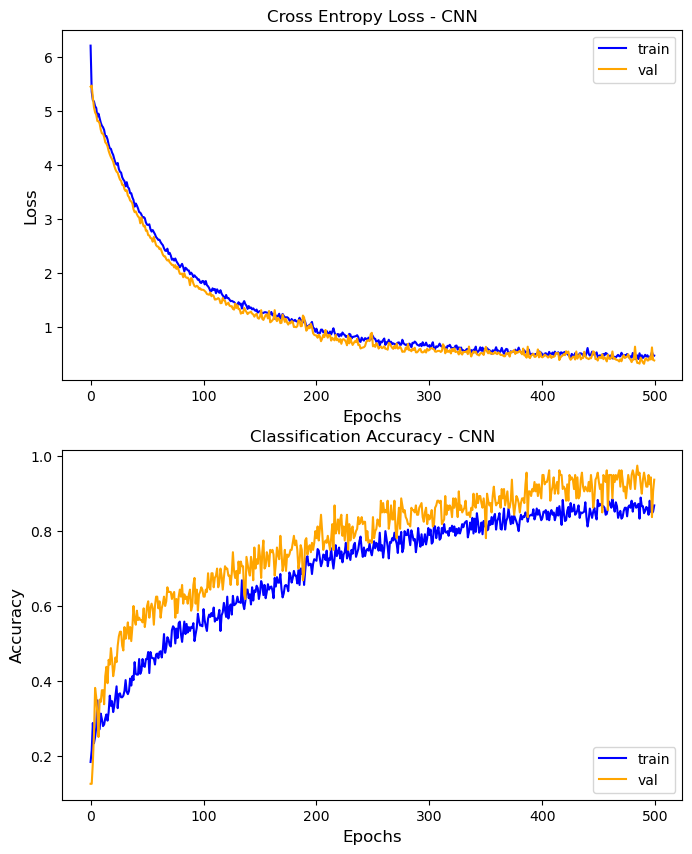

In [11]:
def history_plot(model_id, history):
    plt.figure(figsize=(8,10))
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss - '+model_id, fontsize=12)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy - '+model_id, fontsize=12)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    
    plt.show()

history_plot('CNN', history)

# Save Model

In [12]:
MODEL_PATH = 'model/test/'
model.save(MODEL_PATH+'CNN_multiclass')

INFO:tensorflow:Assets written to: model/test/CNN_multiclass\assets


INFO:tensorflow:Assets written to: model/test/CNN_multiclass\assets


# Load Model

In [13]:
MODEL_PATH = 'model/test/'
model = load_model(MODEL_PATH+'CNN_multiclass')

# Prediction On Test

In [14]:
batch_size = 32
test_gen = image_gen_test.flow(np.array(x_test), batch_size=batch_size, shuffle=False)
steps_test = x_test.shape[0] // batch_size

print('predicting ...')
prediction = model.predict(test_gen, steps=steps_test)
y_pred = to_categorical(np.argmax(prediction, axis=1), nb_classes)
print('done')

predicting ...
5/5 [==============================] - 0s 70ms/step
done


# Model Metrics

In [15]:
# accuracy
accuracy_score(y_test, y_pred)

0.9625

In [16]:
print('Macro')
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print('\nWeighted')
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

Macro
0.9672619047619048
0.9624999999999999
0.9627882829102341

Weighted
0.9672619047619048
0.9625
0.962788282910234


In [17]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

# confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), prediction.argmax(axis=1))
cm

                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        20
           forest       1.00      0.95      0.97        20
   mobilehomepark       1.00      0.85      0.92        20
         overpass       0.95      1.00      0.98        20
       parkinglot       0.83      1.00      0.91        20
            river       0.95      1.00      0.98        20
           runway       1.00      0.95      0.97        20
sparseresidential       1.00      0.95      0.97        20

        micro avg       0.96      0.96      0.96       160
        macro avg       0.97      0.96      0.96       160
     weighted avg       0.97      0.96      0.96       160
      samples avg       0.96      0.96      0.96       160



array([[20,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 17,  0,  3,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 19]], dtype=int64)

5/5 [==============================] - 0s 73ms/step


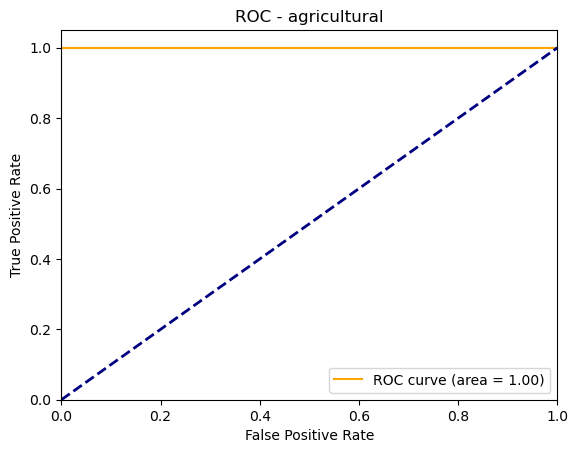

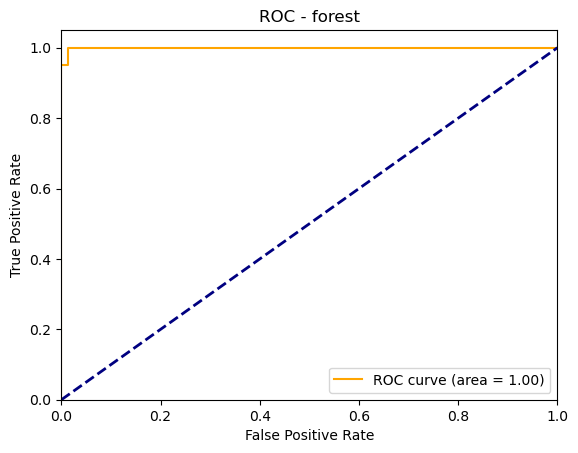

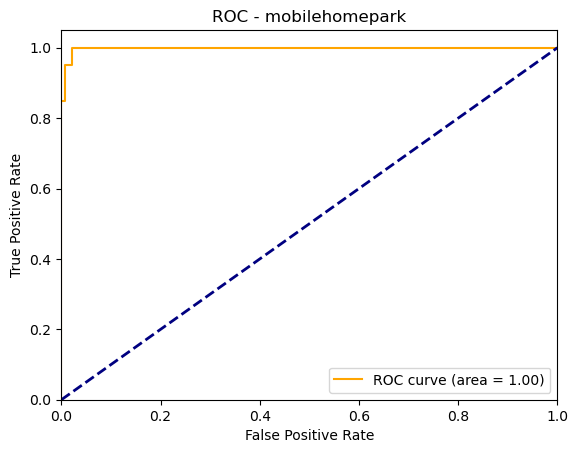

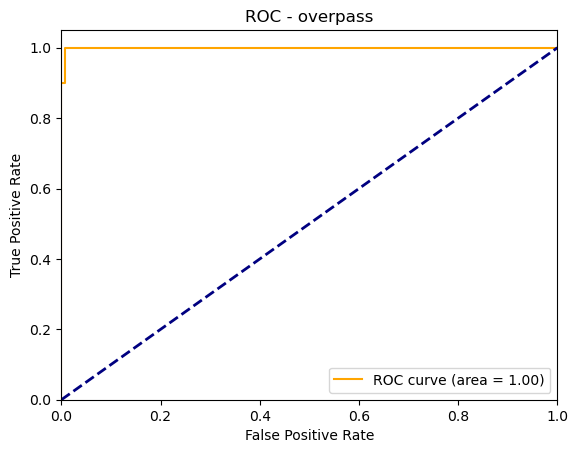

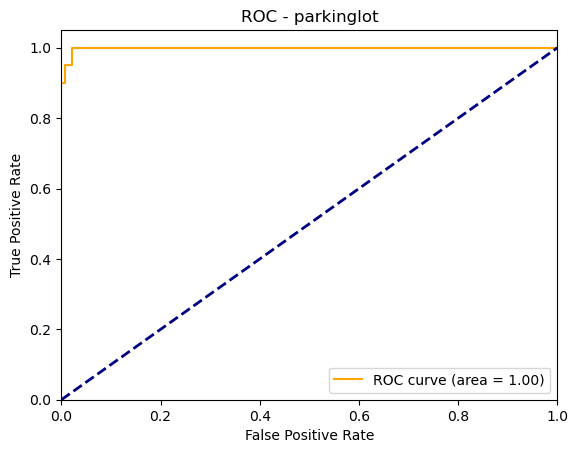

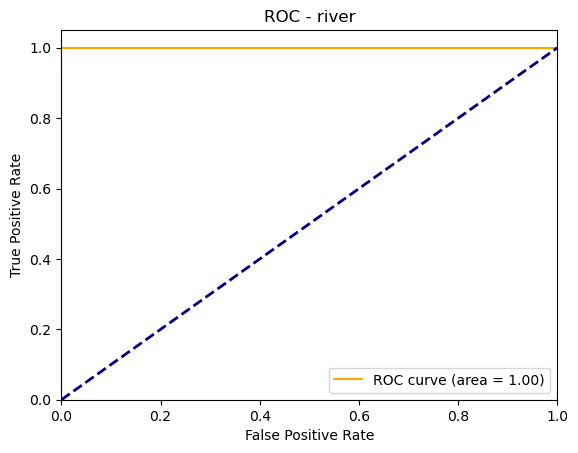

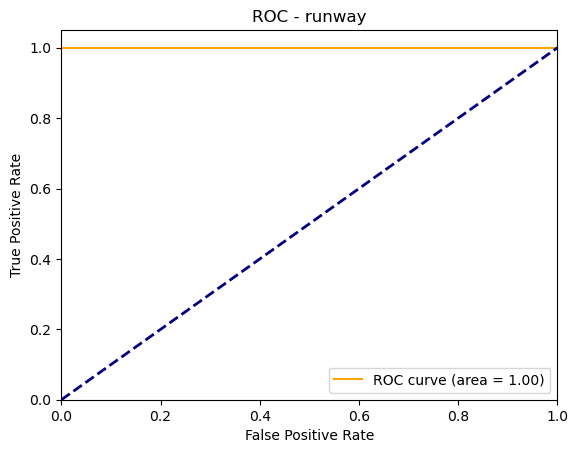

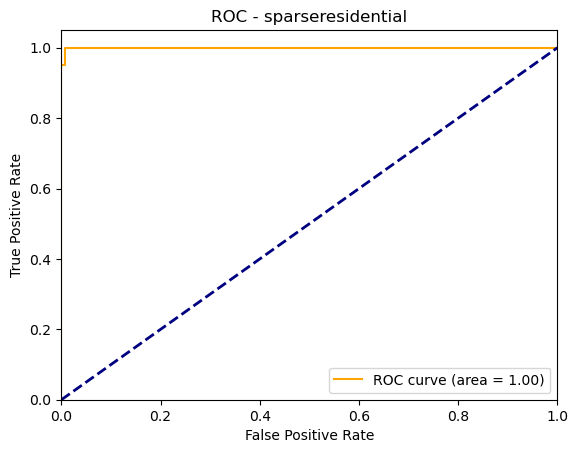

In [18]:
y_score = model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(nb_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - '+category_names[i])
    plt.legend()
    plt.show()

# Model Visualization

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       5

Filter 0


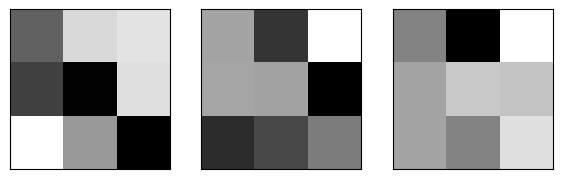

Filter 1


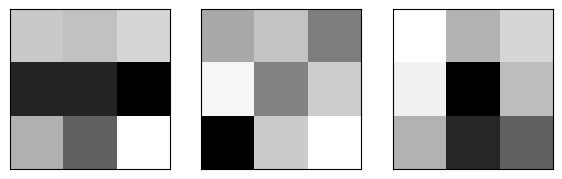

Filter 2


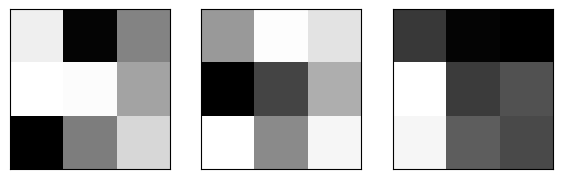

Filter 3


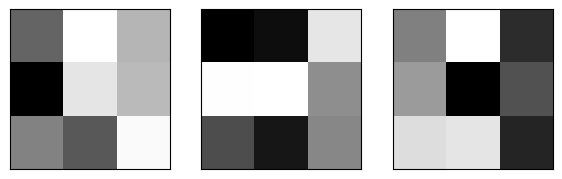

Filter 4


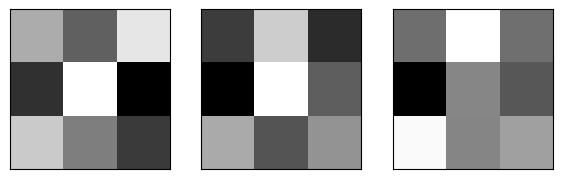

Filter 5


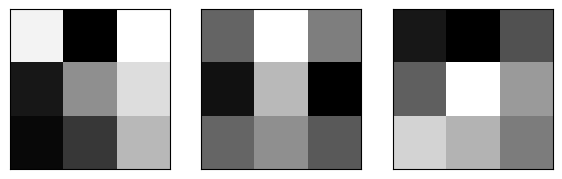

In [20]:
# visualize filters

filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 6, 1
for i in range(n_filters):
    print('Filter', i)
    plt.figure(figsize=(7,40))
    f = filters[:,:,:,i]
    # plot each channel
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,j], cmap='gray')
        ix += 1
    plt.show()

(-0.5, 63.5, 63.5, -0.5)

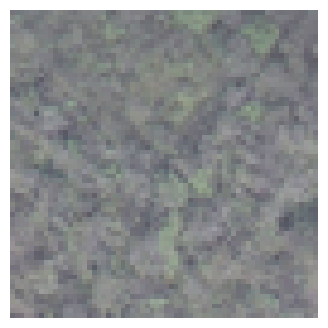

In [21]:
# select a random image

img = images_orig[111].reshape(1, 64, 64, 3)
fig = plt.figure(figsize=(4,4))
plt.imshow(img[0,:,:])
plt.axis('off')

1/1 [==============================] - 0s 57ms/step
Layer 0: conv2d_3


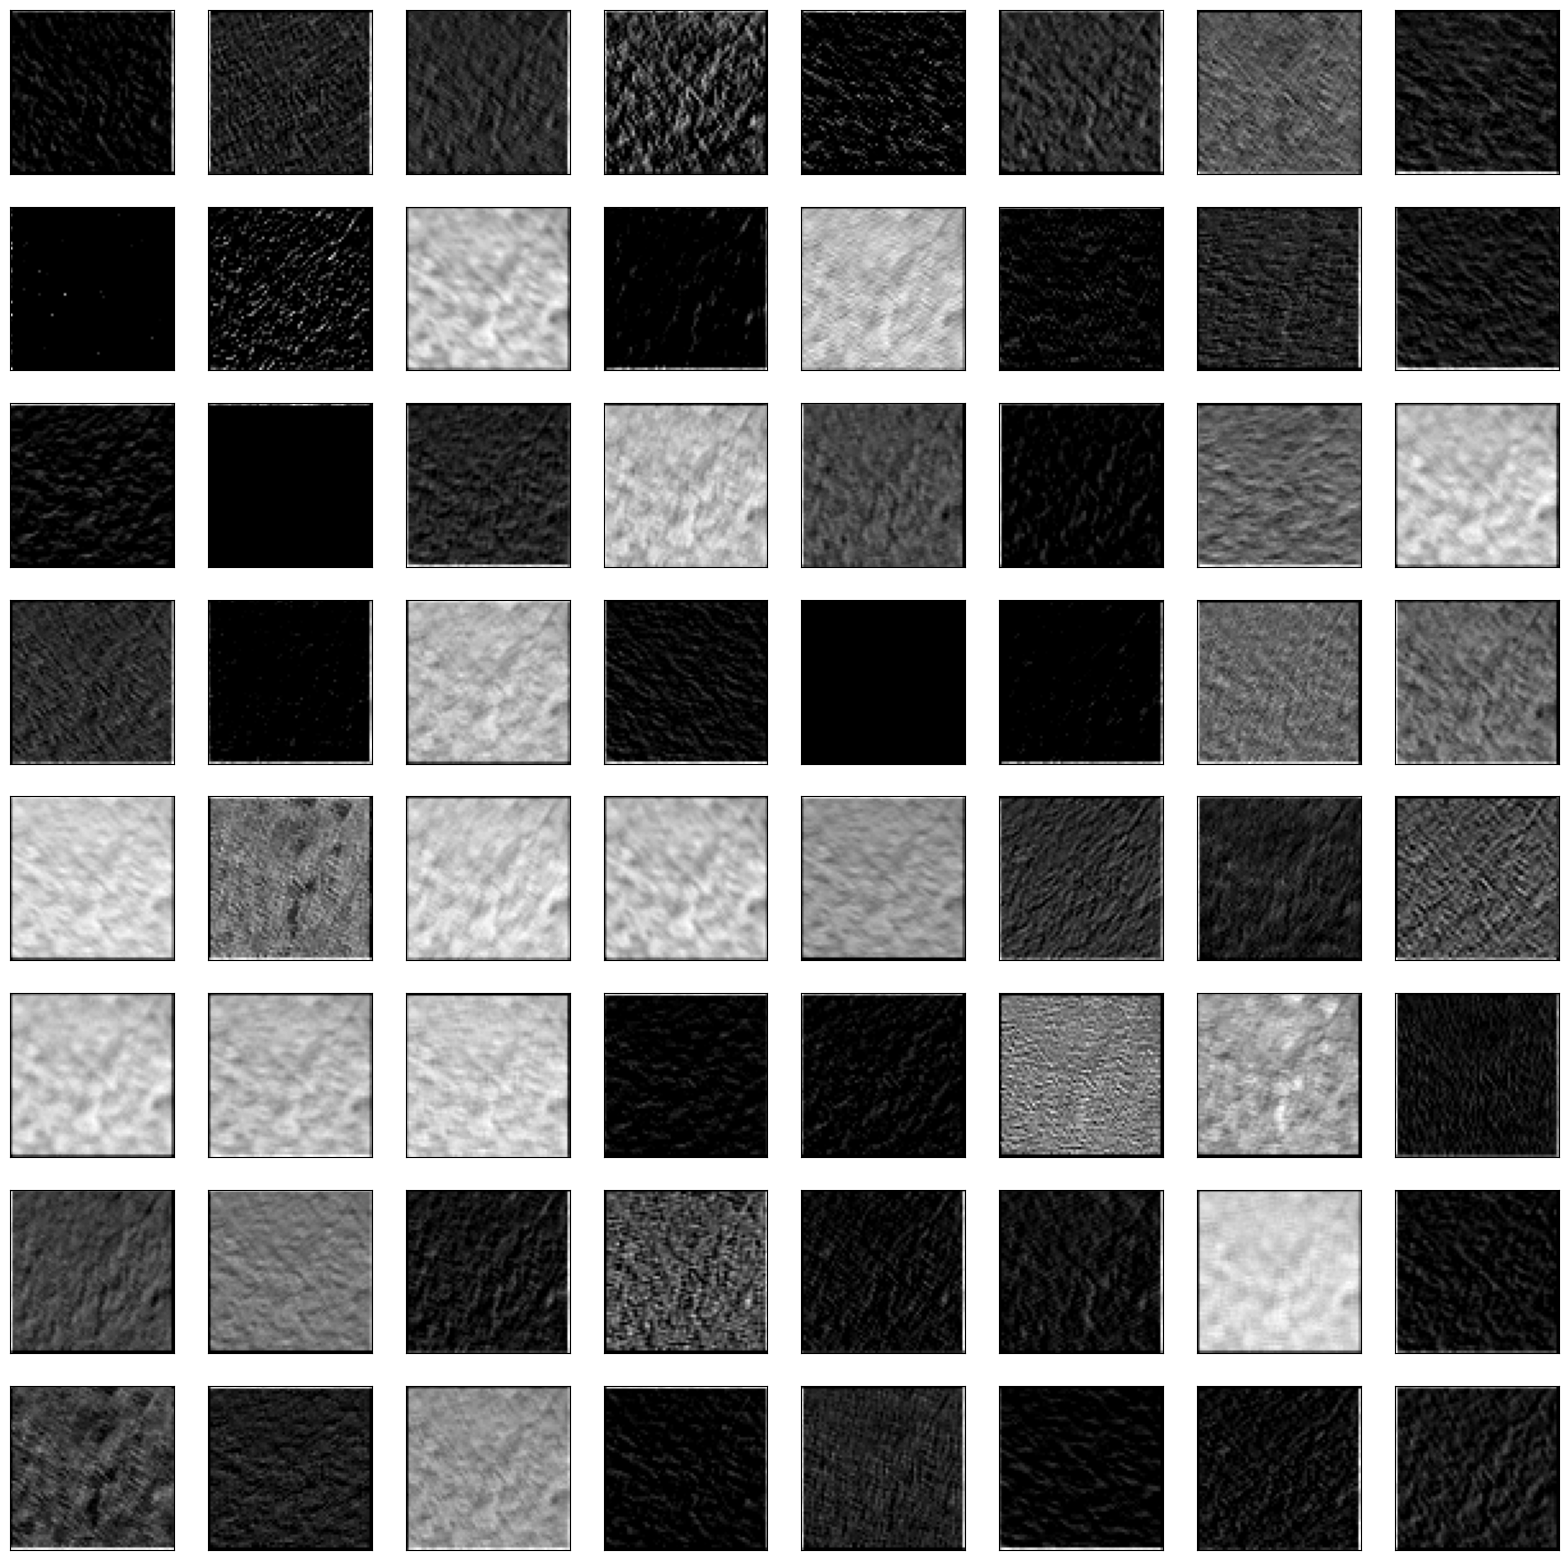

Layer 1: max_pooling2d_3


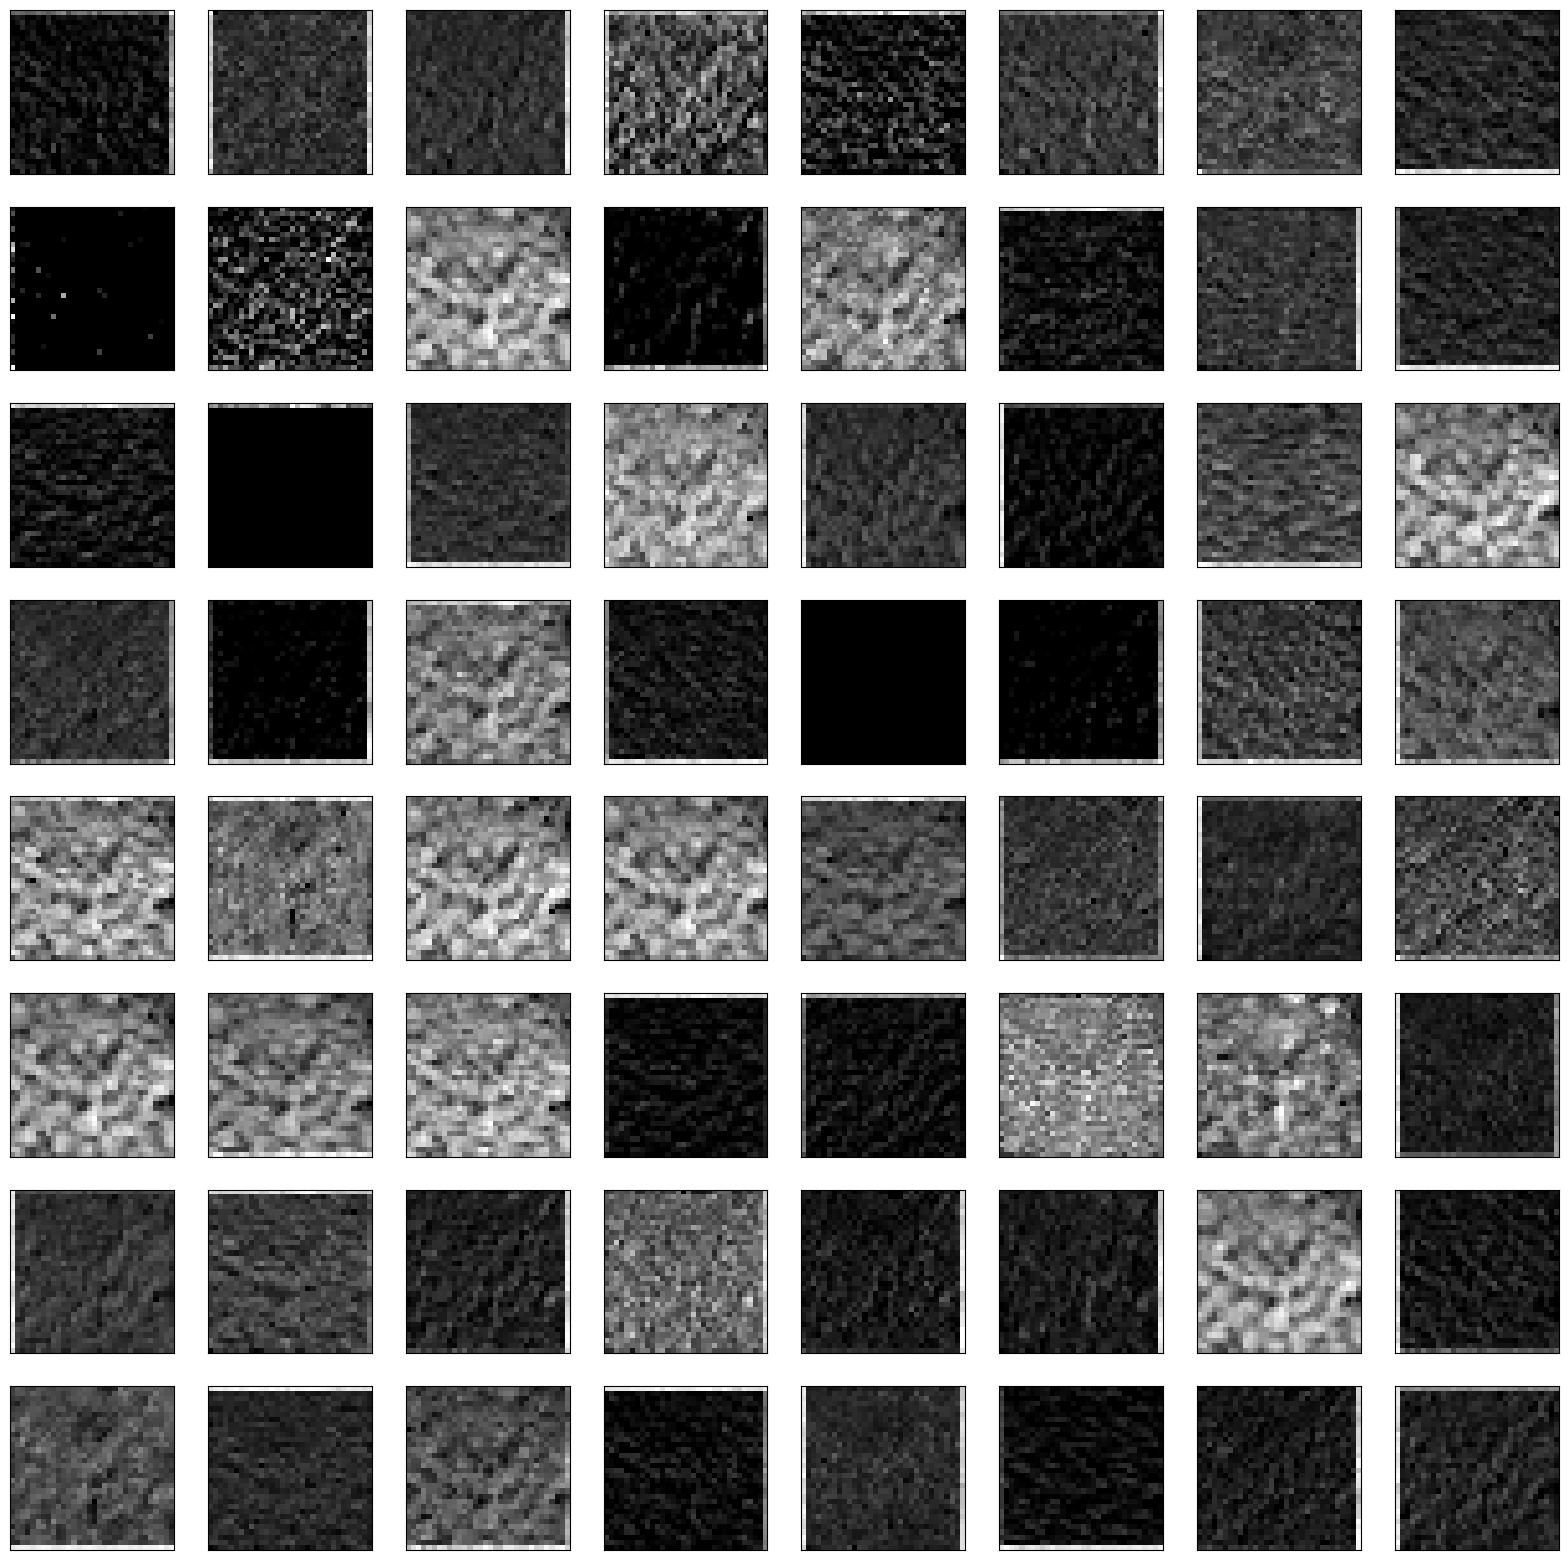

Layer 2: conv2d_4


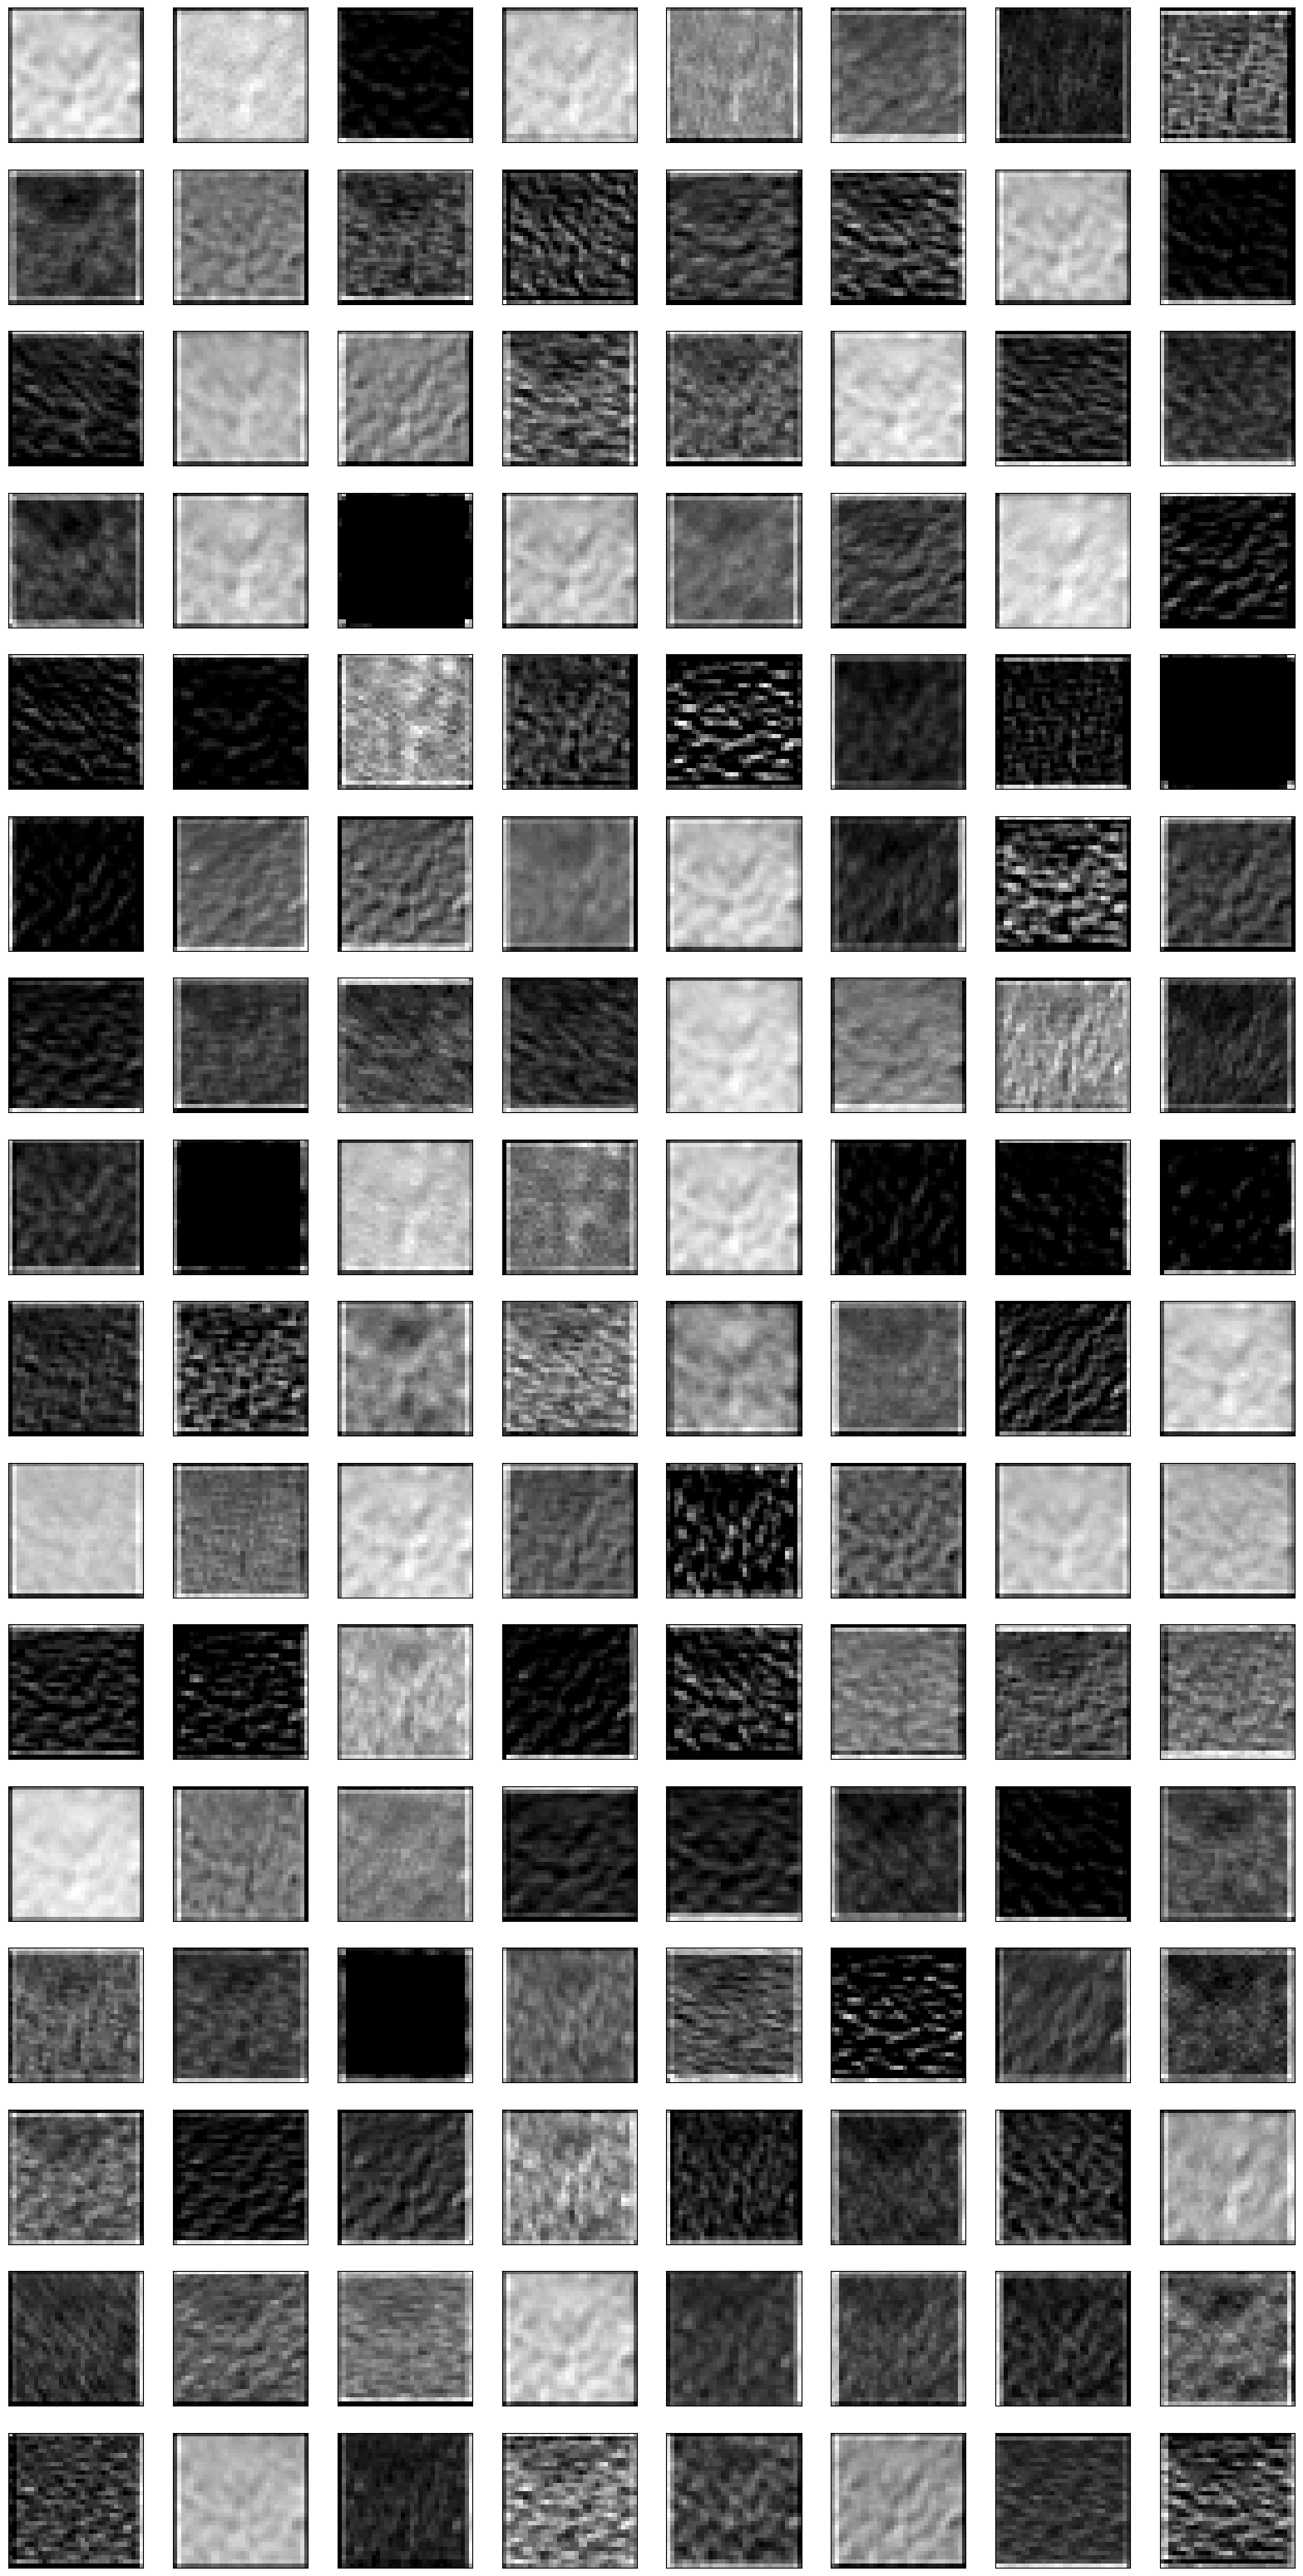

Layer 3: max_pooling2d_4


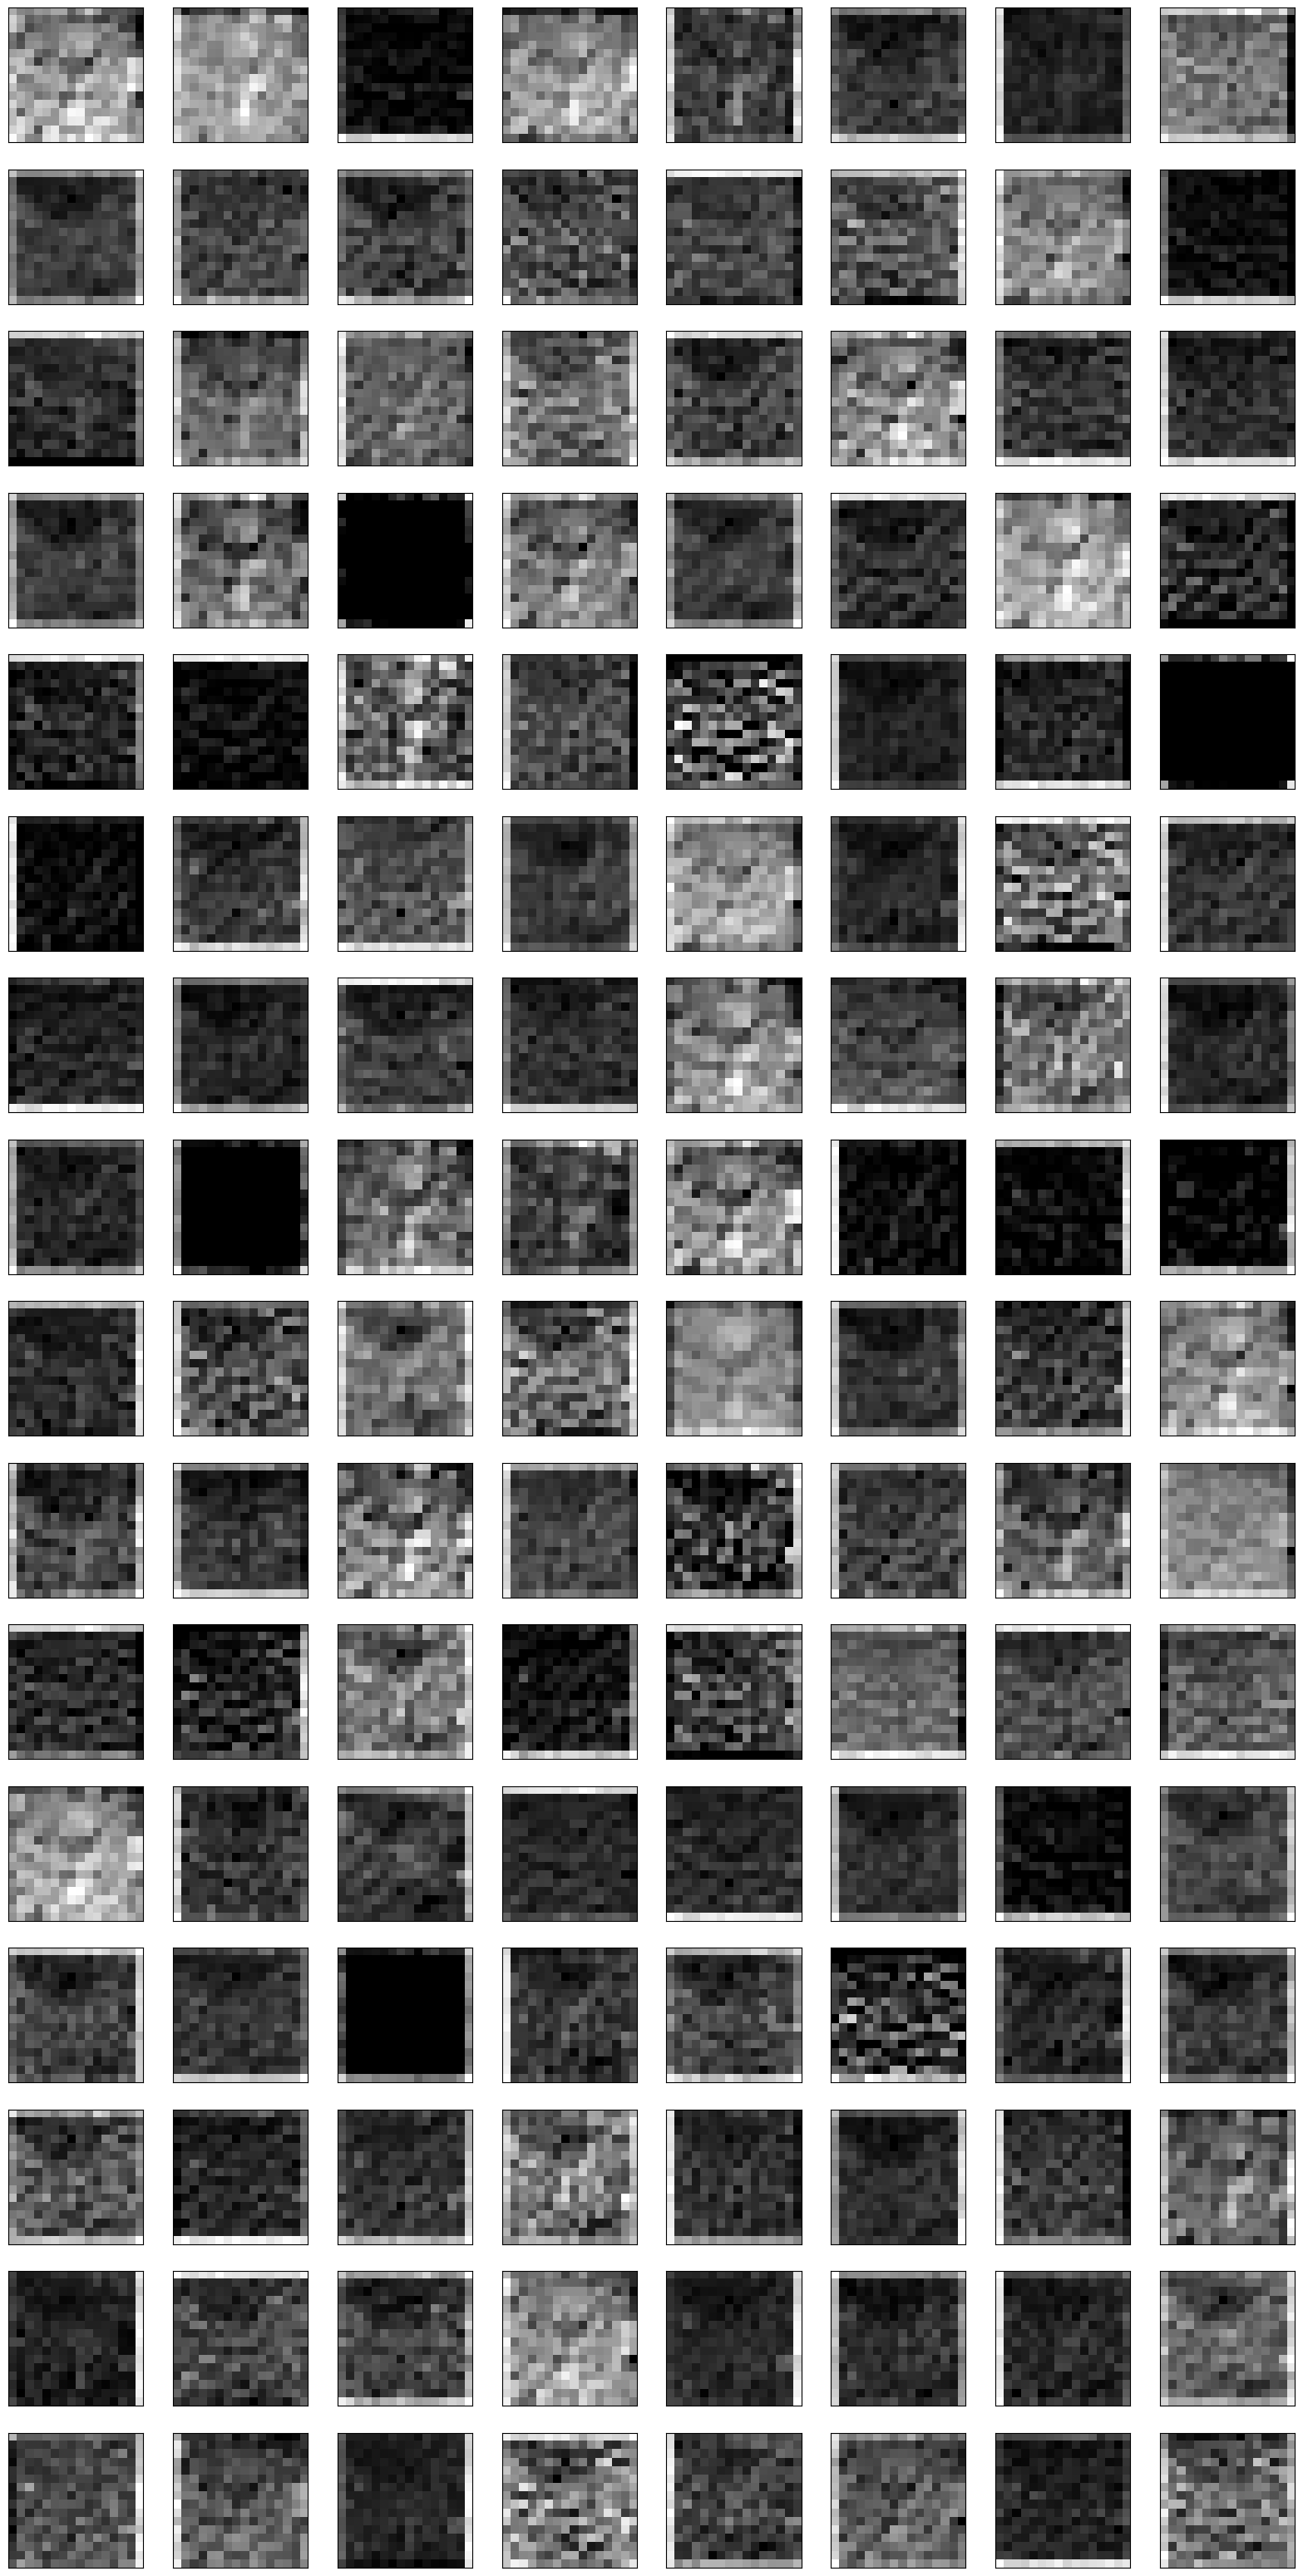

Layer 4: conv2d_5


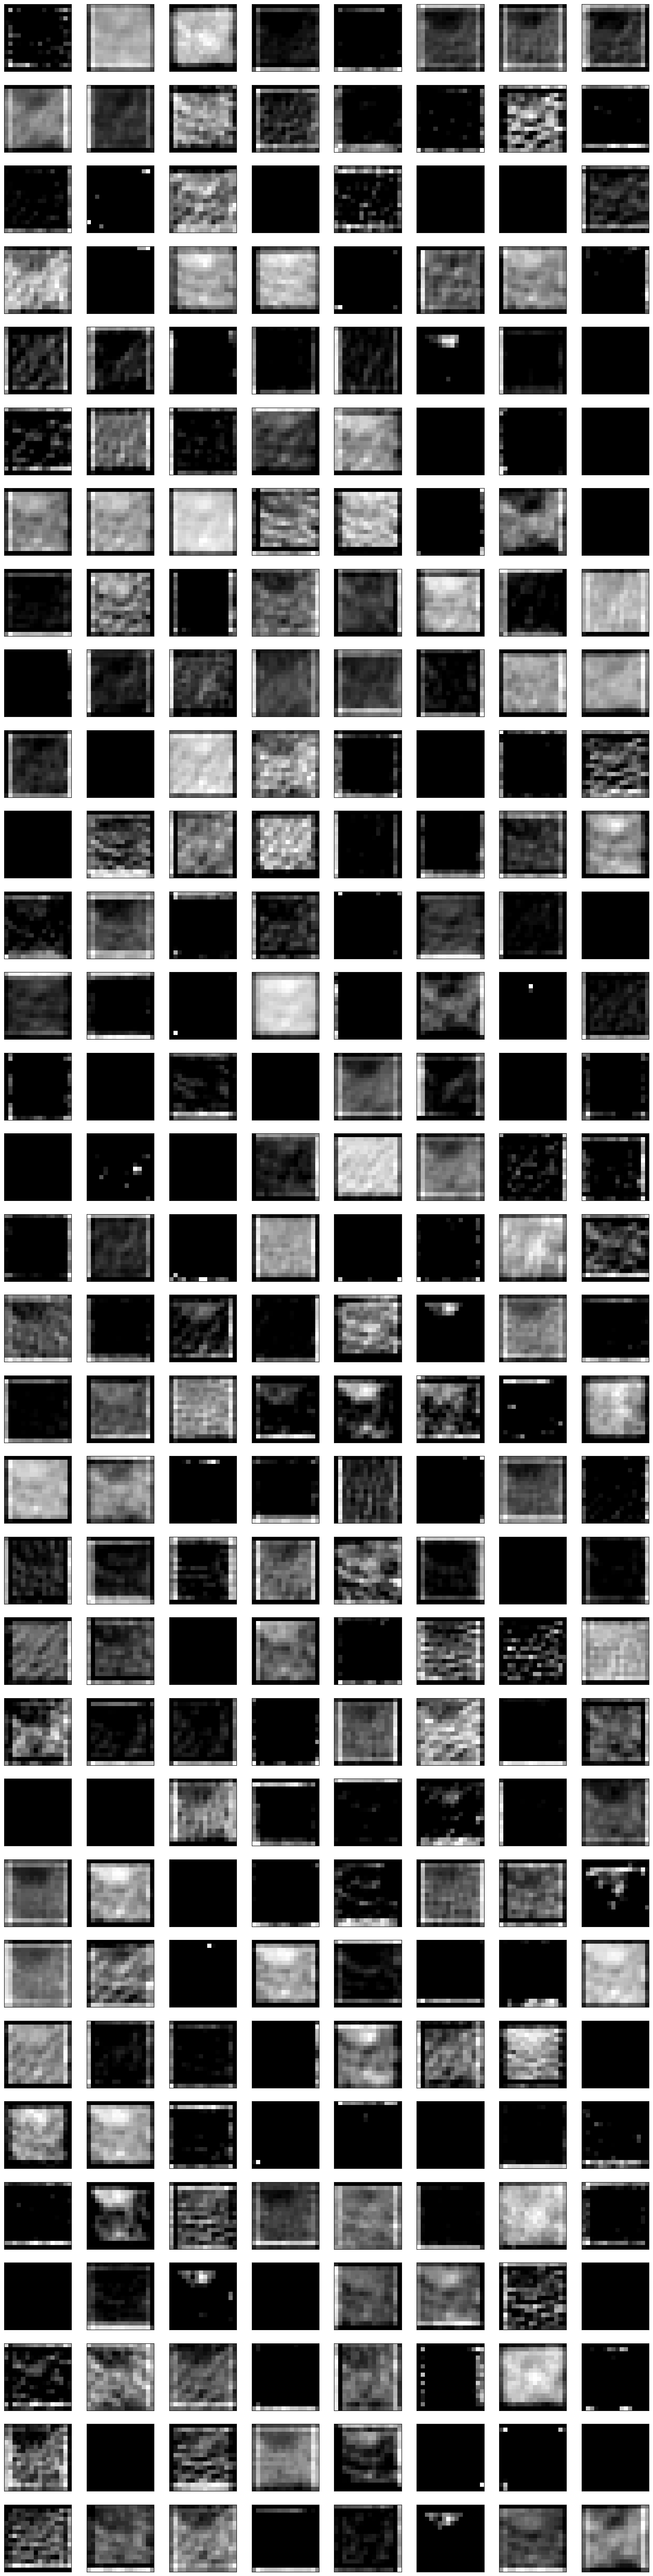

Layer 5: max_pooling2d_5


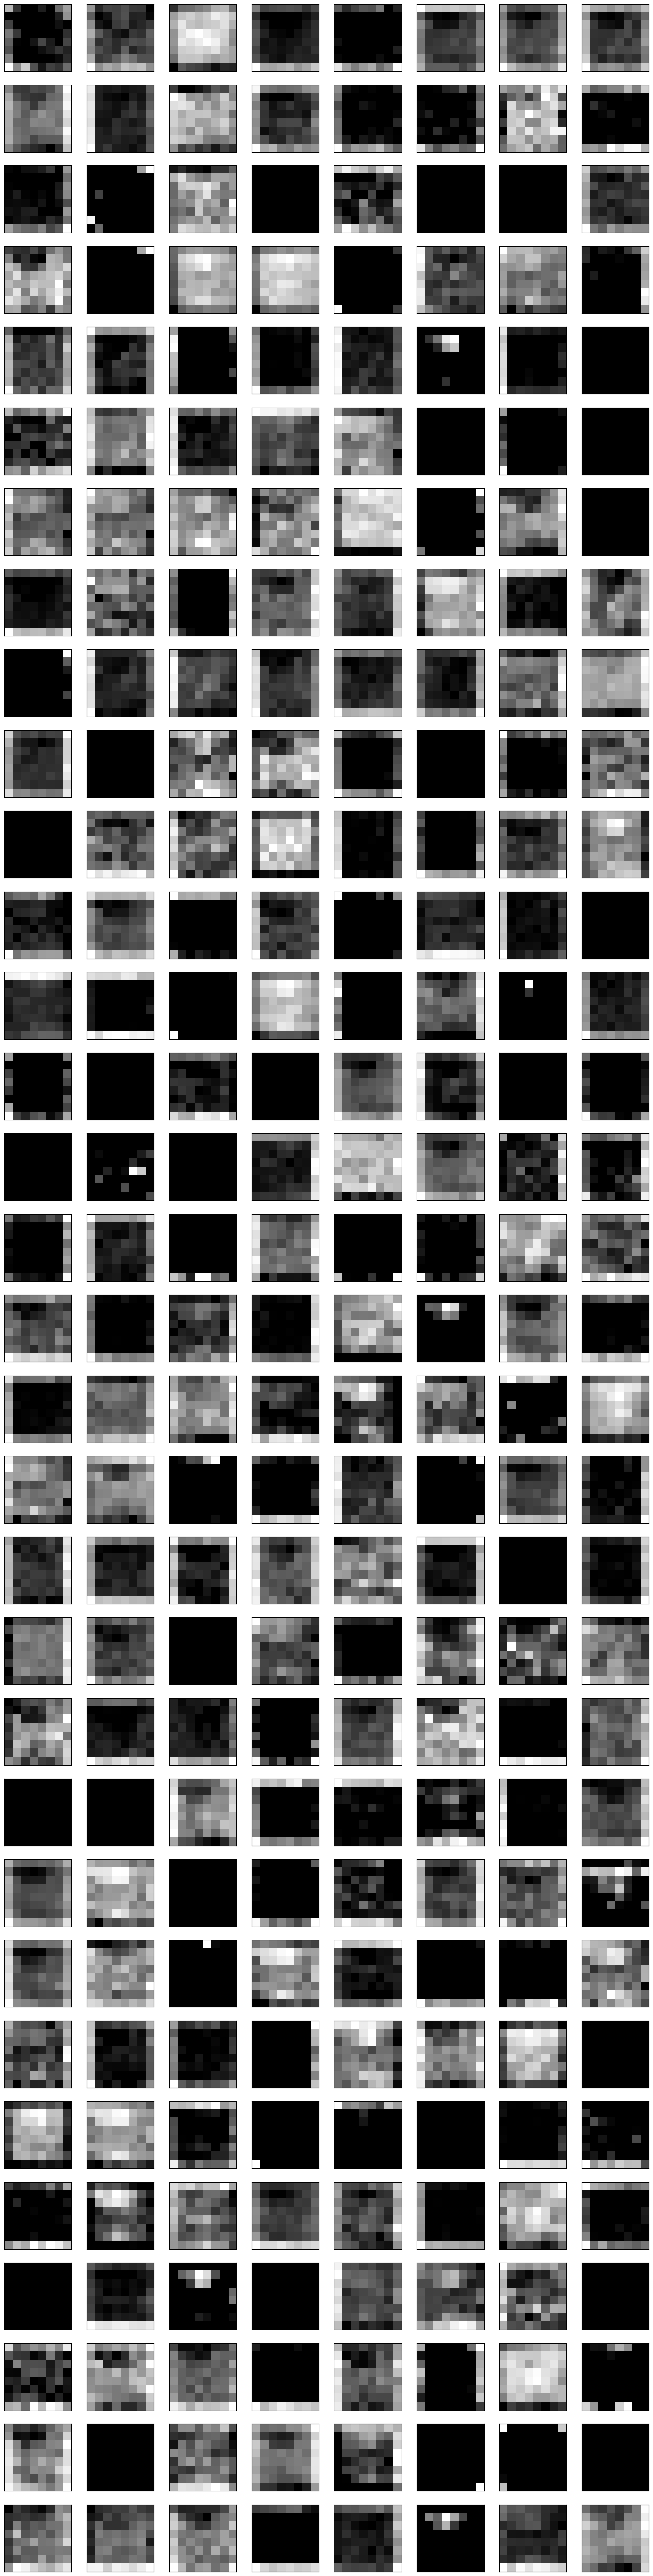

In [36]:
# visualize feature maps

outputs = [model.layers[i].output for i in range(0,6)]
model_v = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model_v.predict(img)

square = 8
i = 0
for fm in feature_maps:
    plt.figure(figsize=(20,max(20,20*fm.shape[-1]//(square*square))))
    ix = 1
    print('Layer {}: {}'.format(i,model.layers[i].name))
    i += 1
    for _ in range(fm.shape[-1]//square):
        for _ in range(square):
            ax = plt.subplot(fm.shape[-1]//square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fm[0,:,:,ix-1], cmap='gray')
            ix += 1
    plt.show()